In [1]:
import numpy as np
import pandas as pd

from etl import load_monsters, _mechanics, _stats, _flavor, _skills, get_monster_df

# Load data

In [2]:
monsters, ogl = load_monsters()
monster_df = get_monster_df(monsters)

In [3]:
monster_df[_mechanics].head()

,challenge_rating,armor_class,hit_dice,hit_points,condition_immunities,damage_immunities,damage_resistances,damage_vulnerabilities,actions,reactions,legendary_actions,special_abilities,size,speed,senses
name,,,,,,,,,,,,,,,
Aboleth,10.00,17,18d10,135,,,,,"[{'name': 'Multiattack', 'desc': 'The aboleth ...",[],"[{'name': 'Detect', 'desc': 'The aboleth makes...","[{'name': 'Amphibious', 'desc': 'The aboleth c...",Large,"10 ft., swim 40 ft.","darkvision 120 ft., passive Perception 20"
Acolyte,0.25,10,2d8,9,,,,,"[{'name': 'Club', 'desc': 'Melee Weapon Attack...",[],[],"[{'name': 'Spellcasting', 'desc': 'The acolyte...",Medium,30 ft.,passive Perception 12
Adult Black Dragon,14.00,19,17d12,195,,acid,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],"[{'name': 'Detect', 'desc': 'The dragon makes ...","[{'name': 'Amphibious', 'desc': 'The dragon ca...",Huge,"40 ft., fly 80 ft., swim 40 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Blue Dracolich,17.00,19,18d12,225,"charmed, exhaustion, frightened, paralyzed, po...","lightning, poison",necrotic,,"[{'name': 'Multiattack', 'desc': 'The dracolic...",[],"[{'name': 'Detect', 'desc': 'The dracolich mak...","[{'name': 'Legendary Resistance (3/Day)', 'des...",Huge,"40 ft., burrow 30 ft., fly 80 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Blue Dragon,16.00,19,18d12,225,,lightning,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],"[{'name': 'Detect', 'desc': 'The dragon makes ...","[{'name': 'Legendary Resistance (3/Day)', 'des...",Huge,"40 ft., burrow 30 ft., fly 80 ft.","blindsight 60 ft., darkvision 120 ft., passive..."


# Feature extraction
At this stage, we'll restrict ourselves to simple feature extraction and engineering. Let's first consider the `actions` column of `monster_df`. We first familiarize ourselves with the data.

In [4]:
from functools import reduce
actions_keys = {tuple(action.keys()) for actions in monster_df.actions for action in actions}
actions_keys

{('name', 'desc', 'attack_bonus'),
 ('name', 'desc', 'attack_bonus', 'damage_bonus'),
 ('name', 'desc', 'attack_bonus', 'damage_dice'),
 ('name', 'desc', 'attack_bonus', 'damage_dice', 'damage_bonus')}

In [5]:
from functools import partial

def has_properties(x, pos=[], neg=[]):
    return any(all([z in y for z in pos] + [z not in y for z in neg]) for y in x)

In [6]:
from collections import namedtuple
import re

get_dc = partial(re.findall,
                 re.compile(r'\bDC (\d+) (' \
                            + r'|'.join(stat.capitalize() for stat in _stats) \
                            + r')\b'))

get_dice = partial(re.findall, re.compile(r'\b(\d+)?d(\d+)\b'))


def parse_actions(actions):
    multi = False
    for action in actions:
        if action['name'] == 'Multiattack':
            multi = True
            continue
        attack_bonus = action.get('attack_bonus', 0)
        damage_bonus = action.get('damage_bonus', 0)
        damage_dice = action.get('damage_dice', '')
        dcs = get_dc(action.get('desc'))
    return multi, attack_bonus, damage_bonus, damage_dice, dcs

In [7]:
neg=['damage_dice', 'damage_bonus']
def has_special_action(actions):
    return any(is_special_action(action) for action in actions)

def is_special_action(action):
    return 'Multiattack' not in action['name'] and all([z not in action for z in neg])

def get_special_action(actions):
    return [action for action in actions if is_special_action(action)]

monster_df.actions[monster_df.actions.apply(has_special_action)].apply(get_special_action).head()

name
Aboleth                 [{'name': 'Enslave (3/day)', 'desc': 'The abol...
Adult Black Dragon      [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Blue Dracolich    [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Blue Dragon       [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Brass Dragon      [{'name': 'Frightful Presence', 'desc': 'Each ...
Name: actions, dtype: object

## Actions

In [8]:
from collections import namedtuple
Summary = namedtuple('Summary', field_names='has_multiattack attack_bonus damage difficulty_class')

def summarize_actions(actions):
    has_multiattack = 1 if any('Multiattack' in action['name'] for action in actions) else 0
    action_summaries = [summarize(action) for action in actions]
    if action_summaries:
        max_attack_bonus = max(action['attack_bonus'] for action in action_summaries)
        max_damage = max(action['damage'] for action in action_summaries)
        max_difficulty_class = max(action['difficulty_class'] for action in action_summaries)
        summary = Summary(has_multiattack=has_multiattack, 
                          attack_bonus=max_attack_bonus, 
                          damage=max_damage, 
                          difficulty_class=max_difficulty_class)
    else:
        summary = Summary(has_multiattack=0,
                          attack_bonus=2,
                          damage=1,
                          difficulty_class=10)
    return summary


def summarize(action):
    difficulty_class = get_dc(action['desc'])
    attack_bonus = int(action.get('attack_bonus', '0'))
    damage_dice = action.get('damage_dice', '0d0')
    damage_bonus = int(action.get('damage_bonus', '0'))
    return {'attack_bonus': attack_bonus,
            'damage': get_damage_potential(damage_dice, damage_bonus),
            'difficulty_class': get_max_dc(difficulty_class)}

def get_damage_potential(damage_dice, damage_bonus):
    damage = damage_bonus
    for roll in damage_dice.split(' + '):
        n, size = get_dice(roll)[0]
        damage += int(n) * int(size)
    return damage

def get_max_dc(difficulty_class):
    if difficulty_class:
        return max([int(x[0]) for x in difficulty_class if x])
    else:
        return 10

In [9]:
attacks = monster_df.actions.apply(summarize_actions)

In [10]:
attacks_df = pd.concat([attacks.map(lambda x: x[i]) for i in range(4)], axis=1)
attacks_df.columns = 'has_multiattack attack_bonus damage difficulty_class'.split(' ')

# quick linear model

In [11]:
X = pd.concat([monster_df[['armor_class', 'hit_points']], attacks_df], axis=1)
y = monster_df[['challenge_rating']]

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

pred = y.copy()
pred['cr_hat'] = lr.predict(X)

/Users/jason/Code/cr/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


/Users/jason/Code/cr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


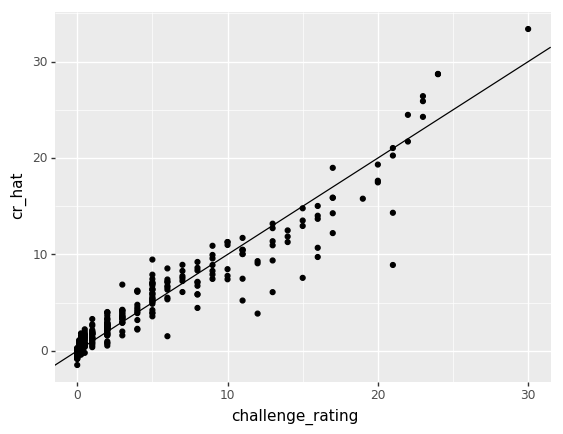

<ggplot: (-9223372036574592305)>

In [13]:
from plotnine import (aes, geom_abline, geom_point, ggplot)
ggplot(pred, aes(x='challenge_rating', y='cr_hat')) + geom_point() + geom_abline(intercept = 0, slope = 1)

In [14]:
lr.score(X, y)

0.91243233372362997

# Simple neural network

In [15]:
X.head()

,armor_class,hit_points,has_multiattack,attack_bonus,damage,difficulty_class
name,,,,,,
Aboleth,17,135,1,9,23,14
Acolyte,10,9,0,2,4,10
Adult Black Dragon,19,195,1,11,96,18
Adult Blue Dracolich,19,225,1,12,120,20
Adult Blue Dragon,19,225,1,12,120,19


In [16]:
y.head()

,challenge_rating
name,
Aboleth,10.00
Acolyte,0.25
Adult Black Dragon,14.00
Adult Blue Dracolich,17.00
Adult Blue Dragon,16.00


In [17]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

Using TensorFlow backend.


In [27]:
from sklearn.preprocessing import StandardScaler

# pre-processing
scale_x, scale_y = StandardScaler(),  StandardScaler()
sX = scale_x.fit_transform(X)
sy = scale_y.fit_transform(y)


In [54]:
# A simple example of linear regression.
model = Sequential()
model.add(Dense(1, input_shape=(6,)))
model.compile(loss='mean_squared_error', optimizer=SGD())

In [60]:
# training
# network_history = model.fit(X_train, Y_train, epochs=200, verbose=0, validation_data=(X_val, Y_val))
network_history = model.fit(sX, sy, epochs=200, verbose=0)

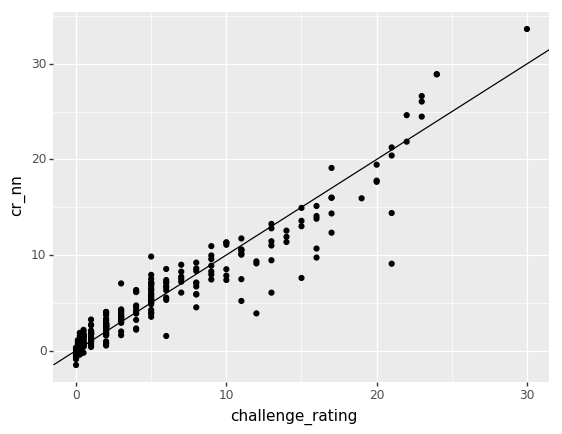

<ggplot: (-9223372036578088090)>

In [61]:
y_hat = scale_y.inverse_transform(model.predict(sX))
pred['cr_nn'] = y_hat

ggplot(pred, aes(x='challenge_rating', y='cr_nn')) + geom_point() + geom_abline(intercept = 0, slope = 1)

The difference in results between linear regression and the neural network are due entirely to the optimization strategies. In the case of sci-kit learn, regression is simply a matter of linear algebra, whereas keras makes use of stochastic gradient descent.

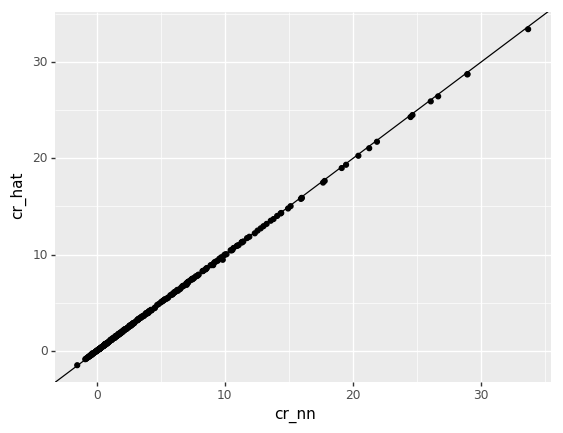

<ggplot: (293030078)>

In [62]:
ggplot(pred, aes(x='cr_nn', y='cr_hat')) + geom_point() + geom_abline(intercept = 0, slope = 1)

# DeepDreaming - or perturbing data for fun and profit

In [24]:
from keras import backend as K

# Generalizing to neural networks with hidden layers